In [1]:
from fastapi import FastAPI
from fastapi.encoders import jsonable_encoder
from dotenv import dotenv_values
from pymongo import MongoClient
from urllib.parse import quote_plus
import certifi
import numpy as np
import time
import pickle
import multiprocessing
import network_data
import power_data
import emanation_data
from scipy import stats
from sklearn.preprocessing import StandardScaler
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import matplotlib.pyplot as plt
import json
import threading
import serial
from paramiko import SSHClient

config = dotenv_values(".env")
username = quote_plus(config["NAME"])
password = quote_plus(config["PASSWORD"])
cluster = config["CLUSTER"]
uri = 'mongodb+srv://' + username + ':' + password + \
    '@' + cluster + '/?retryWrites=true&w=majority'
pineapple_token = "eyJVc2VyIjoicm9vdCIsIkV4cGlyeSI6IjIwMjgtMDgtMjJUMDI6Mzc6NTUuMjk4NzgzMzAzWiIsIlNlcnZlcklkIjoiYTYyMTM3MzE3NTUyNDRlZSJ9.sbCLEXl3vWayXfd4zM2zgTthQnzEztZvWxNi_nejdvg="

client = MongoClient(uri, tlsCAFile=certifi.where())
database = client[config["DB_NAME"]]

print("Connected to the MongoDB database!")
print(client)
print(database)

Connected to the MongoDB database!
MongoClient(host=['cluster0-shard-00-02-f8w36.mongodb.net:27017', 'cluster0-shard-00-00-f8w36.mongodb.net:27017', 'cluster0-shard-00-01-f8w36.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='Cluster0-shard-0', tls=True, tlscafile='/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/certifi/cacert.pem')
Database(MongoClient(host=['cluster0-shard-00-02-f8w36.mongodb.net:27017', 'cluster0-shard-00-00-f8w36.mongodb.net:27017', 'cluster0-shard-00-01-f8w36.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='Cluster0-shard-0', tls=True, tlscafile='/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/certifi/cacert.pem'), 'iotdb')


### Initialization

In [2]:
device = "playing_50"
sample_num = 50
avg_currents, max_currents, min_currents, times = [], [], [], []
current_range_up = 1.0
current_range_bottom = 0
avg_current_up = 0.4
avg_current_bottom = 0.2
max_current_up = 0.8
max_current_bottom = 0.45
min_current_up = 0.15
min_current_bottom = 0

###  Function

In [9]:
def create_data(data):
    database["iotdatas"].insert_one(data)
    print("store data in " + device)


def power_check():
    avg_currents, max_currents, min_currents, times = [], [], [], []
    ser = serial.Serial('/dev/tty.usbmodem21101', 9600, timeout=1)
    start_time = time.time()
    for i in range(sample_num):
        line = ser.readline()
        if line:
            info = line.decode().rstrip()
            infos = info.split(",")
            max_current = float(infos[0])
            avg_current = float(infos[1])
            min_current = float(infos[2])
            avg_currents.append(avg_current)
            max_currents.append(max_current)
            min_currents.append(min_current)
            times.append(time.time() - start_time)
    ser.close()
    print("duration: ", str(times[len(times) - 1] - times[0]))
    return avg_currents, max_currents, min_currents, times


def plot_scatter():
    plt.scatter(times, avg_currents, c="b")
    plt.scatter(times, max_currents, c="r")
    plt.scatter(times, min_currents, c="g")
    plt.xlim(times[0], times[len(times) - 1])
    plt.ylim(current_range_bottom, current_range_up)
    plt.minorticks_on()
    plt.grid(True)
    plt.xlabel('Time (s)')
    plt.ylabel('Current')
    plt.title(device)
    plt.show()


def plot_avg_histogram(ax):
    bin_edges = [i for i in np.arange(
        avg_current_bottom, avg_current_up, 0.005)]
    weights = [1/len(avg_currents)] * len(avg_currents)
    ax.hist(avg_currents, bins=bin_edges, weights=weights,
             color="blue", edgecolor="black")
    ax.set_xlim(avg_current_bottom, avg_current_up)
    ax.grid(True)
    ax.minorticks_on()
    ax.set_xlabel('Current')
    ax.set_ylabel('Percentage')
    ax.set_title("AVG - " + device)


def plot_max_histogram(ax):
    bin_edges = [i for i in np.arange(
        max_current_bottom, max_current_up, 0.005)]
    weights = [1/len(max_currents)] * len(max_currents)
    ax.hist(max_currents, bins=bin_edges, weights=weights,
             color="red", edgecolor="black")
    ax.set_xlim(max_current_bottom, max_current_up)
    ax.grid(True)
    ax.minorticks_on()
    ax.set_xlabel('Current')
    ax.set_ylabel('Percentage')
    ax.set_title("MAX - " + device)


def plot_min_histogram(ax):
    bin_edges = [i for i in np.arange(
        min_current_bottom, min_current_up, 0.005)]
    weights = [1/len(min_currents)] * len(min_currents)
    ax.hist(min_currents, bins=bin_edges, weights=weights,
             color="green", edgecolor="black")
    ax.set_xlim(min_current_bottom, min_current_up)
    ax.grid(True)
    ax.minorticks_on()
    ax.set_xlabel('Current')
    ax.set_ylabel('Percentage')
    ax.set_title("MIN - " + device)


def store_data():
    database["iotdatas"].delete_many({"device": device})
    data = {
        "device": device,
        "max_currents": max_currents,
        "avg_currents": avg_currents,
        "min_currents": min_currents,
        "times": times
    }
    create_data(jsonable_encoder(data))


def get_data(state):
    data = database["iotdatas"].find_one({"device": state})
    avg_currents = data["avg_currents"]
    max_currents = data["max_currents"]
    min_currents = data["min_currents"]
    times = data["times"]

    return avg_currents, max_currents, min_currents, times

## Results (in 1 second)

### test rate

duration:  1.0074172019958496


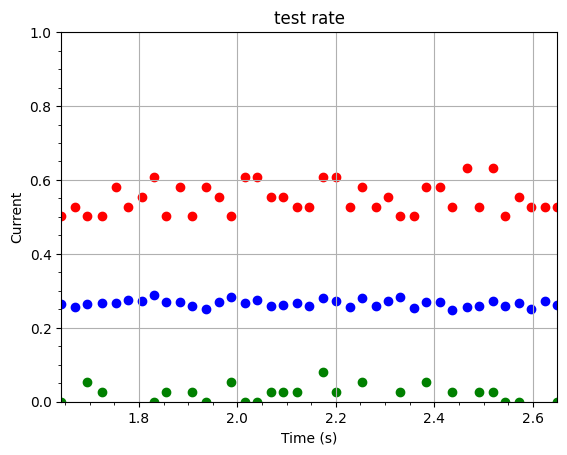

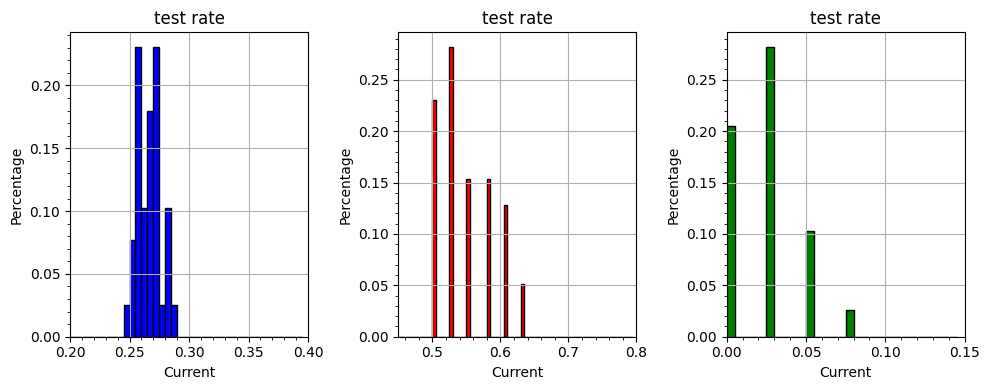

In [7]:
device = "test rate"
sample_num = 40
avg_currents, max_currents, min_currents, times = power_check()
plot_scatter()
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
plot_avg_histogram(axes[0])
plot_max_histogram(axes[1])
plot_min_histogram(axes[2])
plt.tight_layout()

### Power off

duration:  0.9579250812530518


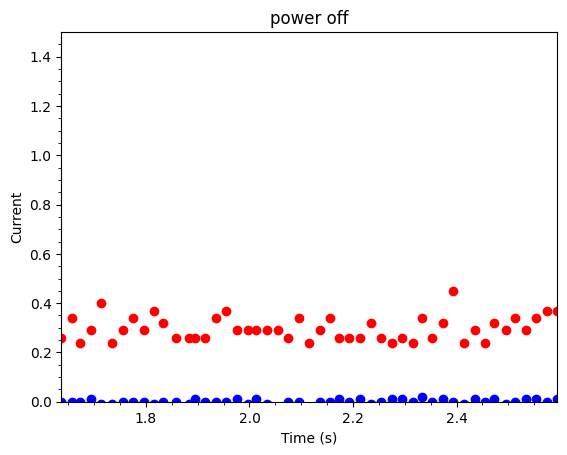

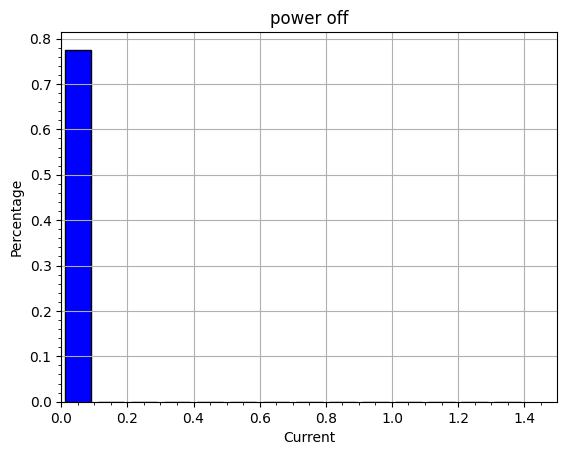

store data in power off


In [11]:
device = "power off"
sample_num = 50
avg_currents, max_currents, min_currents, times = power_check()
plot_scatter()
plot_avg_histogram()
store_data() 

### Muted

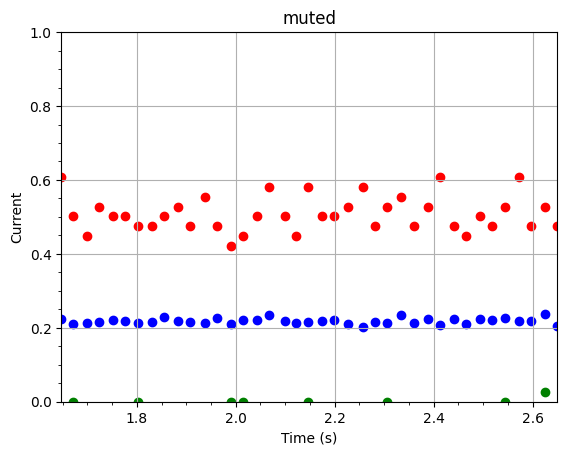

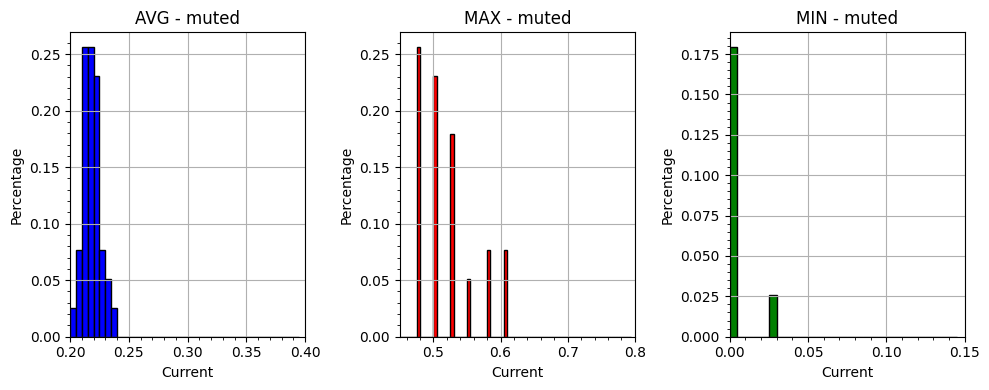

In [10]:
device = "muted"
sample_num = 40
# avg_currents, max_currents, min_currents, times = power_check()
avg_currents, max_currents, min_currents, times = get_data(device)
plot_scatter()
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
plot_avg_histogram(axes[0])
plot_max_histogram(axes[1])
plot_min_histogram(axes[2])
plt.tight_layout()

### Keyword Listening

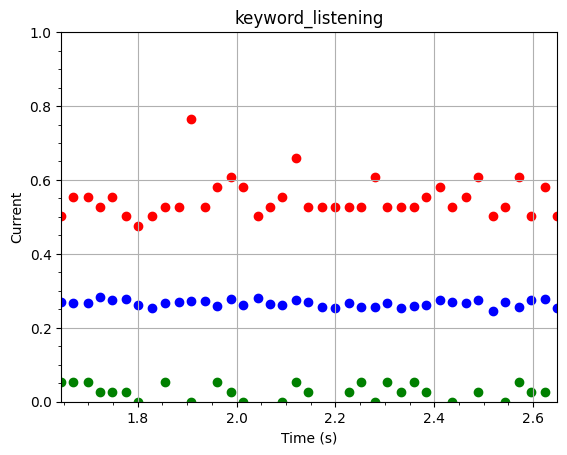

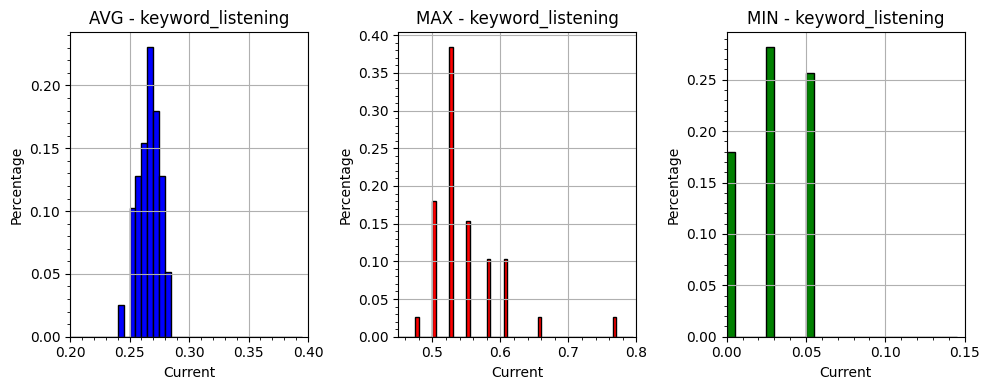

In [12]:
device = "keyword_listening"
sample_num = 40
# avg_currents, max_currents, min_currents, times = power_check()
avg_currents, max_currents, min_currents, times = get_data(device)
plot_scatter()
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
plot_avg_histogram(axes[0])
plot_max_histogram(axes[1])
plot_min_histogram(axes[2])
plt.tight_layout()

### Command Listening

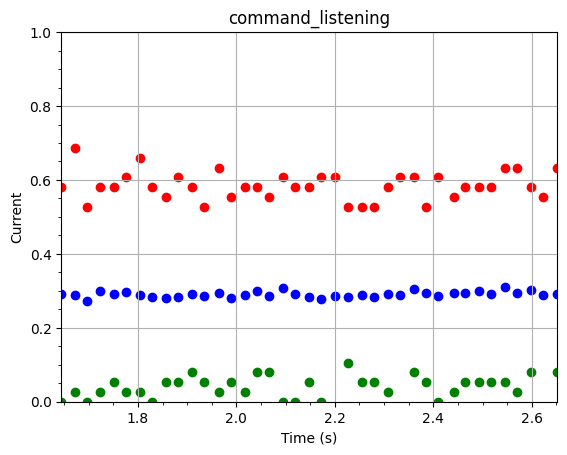

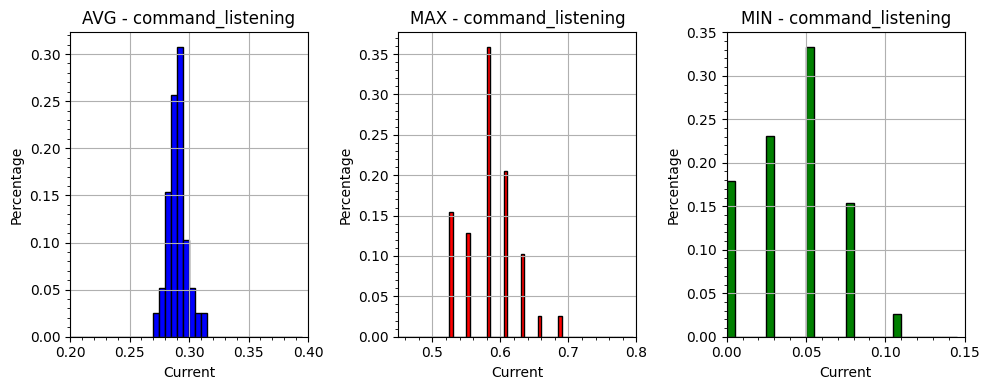

In [13]:
device = "command_listening"
sample_num = 40
# avg_currents, max_currents, min_currents, times = power_check()
avg_currents, max_currents, min_currents, times = get_data(device)
plot_scatter()
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
plot_avg_histogram(axes[0])
plot_max_histogram(axes[1])
plot_min_histogram(axes[2])
plt.tight_layout()

### Playing 25%

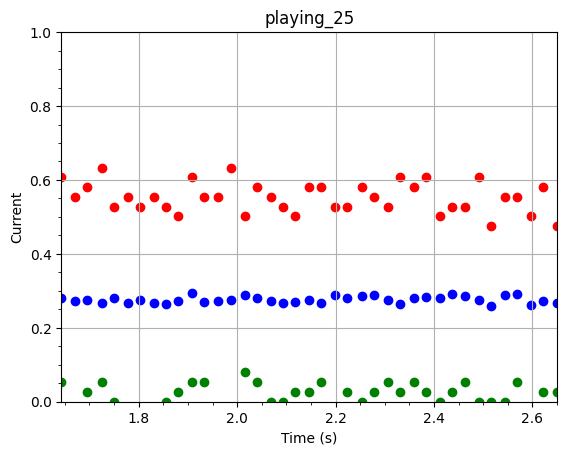

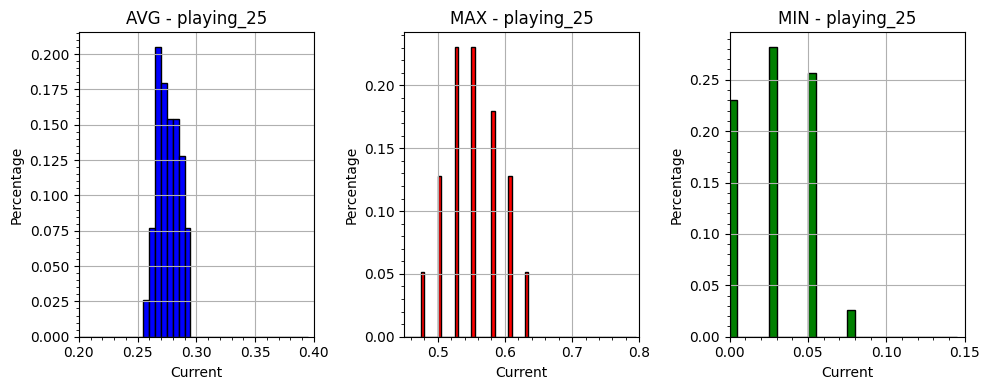

In [14]:
device = "playing_25"
sample_num = 40
# avg_currents, max_currents, min_currents, times = power_check()
avg_currents, max_currents, min_currents, times = get_data(device)
plot_scatter()
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
plot_avg_histogram(axes[0])
plot_max_histogram(axes[1])
plot_min_histogram(axes[2])
plt.tight_layout()

### Playing 50%

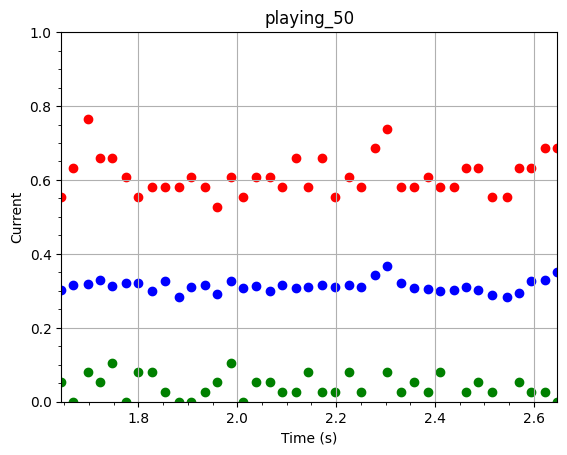

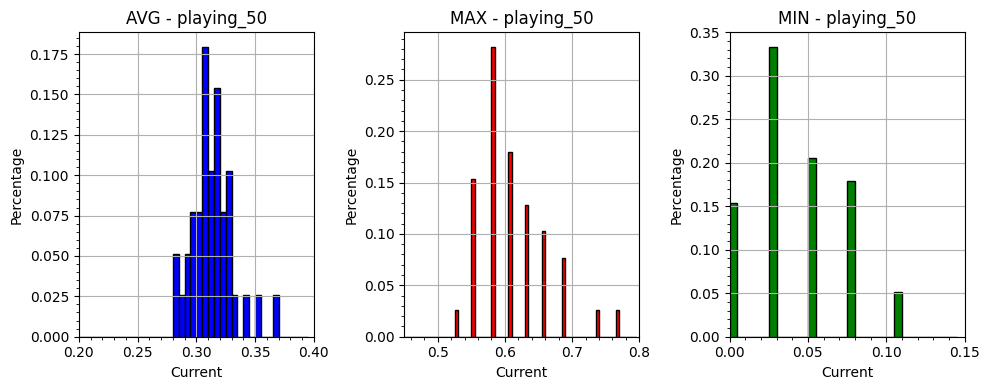

In [15]:
device = "playing_50"
sample_num = 40
# avg_currents, max_currents, min_currents, times = power_check()
avg_currents, max_currents, min_currents, times = get_data(device)
plot_scatter()
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
plot_avg_histogram(axes[0])
plot_max_histogram(axes[1])
plot_min_histogram(axes[2])
plt.tight_layout()

### Playing 75%

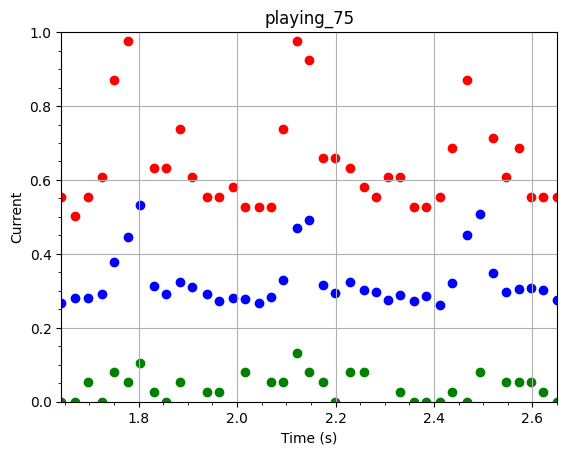

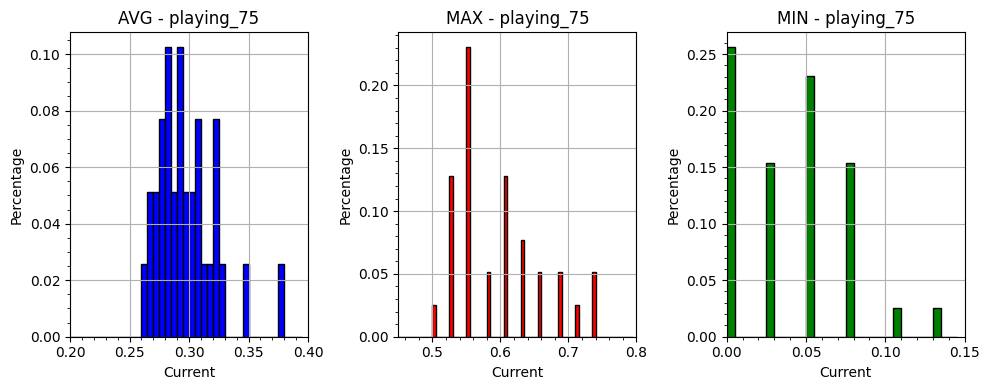

In [16]:
device = "playing_75"
sample_num = 40
# avg_currents, max_currents, min_currents, times = power_check()
avg_currents, max_currents, min_currents, times = get_data(device)
plot_scatter()
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
plot_avg_histogram(axes[0])
plot_max_histogram(axes[1])
plot_min_histogram(axes[2])
plt.tight_layout()

## Training

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

### Build Dataset

In [49]:
states = ["muted", "keyword_listening", "command_listening",
          "playing_25", "playing_50", "playing_75"]
feature_dataset_X = []
feature_dataset_Y = []
scaler_x = StandardScaler()

for state in states:
    avg_currents, max_currents, min_currents, times = get_data(state)
    # divide the datas into 10 groups (4 data per group)
    group_cnt = 10
    group_size = 4
    for i in range(group_cnt):
        avgs = avg_currents[i * group_size:(i + 1) * group_size]
        maxs = max_currents[i * group_size:(i + 1) * group_size]
        mins = min_currents[i * group_size:(i + 1) * group_size]
        avg_features = [fea(avgs) for fea in [
            np.mean, np.std, lambda x: np.max(x) - np.min(x)]]
        max_features = [fea(maxs) for fea in [np.mean, np.std]]
        min_features = [fea(mins) for fea in [np.mean, np.std]]
        features = np.concatenate((avg_features, max_features, min_features))
        feature_dataset_X.append(features)
        feature_dataset_Y.append(states.index(state))

feature_dataset_X = np.array(feature_dataset_X)
feature_dataset_X = scaler_x.fit_transform(feature_dataset_X)
feature_dataset_Y = np.array(feature_dataset_Y)

### Classification

In [50]:
def classify(X, Y, draw):
    # clf = DecisionTreeClassifier()
    clf = RandomForestClassifier(n_estimators=30, random_state=42)

    kf = KFold(n_splits=10, shuffle=True)

    cms = np.zeros((len(states), len(states)))
    acc_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, labels=[i for i in range(len(states))])
        cms += cm

        acc = accuracy_score(y_test, y_pred)
        acc_scores.append(acc)

    avg_accuracy = np.mean(acc_scores)
    if draw:
        plt.figure(figsize=(10, 7))
        cms = cms / 10.0
        sns.heatmap(cms, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=states, 
                    yticklabels=states)

        plt.xlabel('True')
        plt.ylabel('Predict')
        plt.title('Average Confusion Matrix over 10-folds')
        plt.show()

    return avg_accuracy

### Result

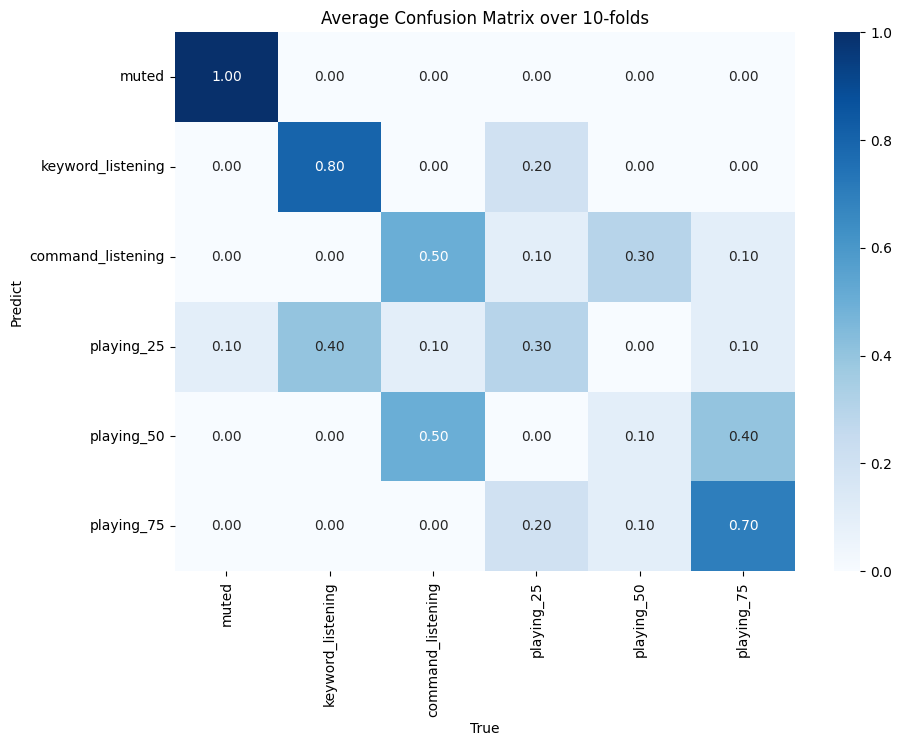

Average Accuracy: 0.5667
Average Accuracy without feature 0: 0.4500
Average Accuracy without feature 1: 0.5833
Average Accuracy without feature 2: 0.6333
Average Accuracy without feature 3: 0.5500
Average Accuracy without feature 4: 0.6333
Average Accuracy without feature 5: 0.6333
Average Accuracy without feature 6: 0.6667


In [55]:
avg_acc = classify(feature_dataset_X, feature_dataset_Y, True)
print(f"Average Accuracy: {avg_acc:.4f}")
# features: avg_avg, avg_std, avg_range, 
#           max_avg, max_std, 
#           min_avg, min_std
features = ["avg_avg", "avg_std", "avg_range", "max_avg", "max_std", "min_avg", "min_std"]
for i in range(len(features)):
    new_dataset_X = np.delete(feature_dataset_X, i, axis=1)
    acc = classify(new_dataset_X, feature_dataset_Y, False)
    print(f"Average Accuracy without {features[i]}: {acc:.4f}")

# test_set = np.delete(feature_dataset_X, [2], axis=1)
# acc = classify(test_set, feature_dataset_Y, True)
# print(acc)
